# Финальный проект- Вариант №1

## Задание №1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
#импортируем библиотеки

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy as sp
from scipy import stats

In [2]:
# Функция retention

def retention(reg_data, auth_data, start_date, end_date, cohort_min_size):
    
    # Загрузим и обработаем таблицы с данными по регистрациям
    df_reg = pd.read_csv(reg_data, sep=';').drop_duplicates()
    df_reg['reg_ts'] =df_reg['reg_ts'].apply(lambda x: datetime.fromtimestamp(x)\
                                                               .strftime('%Y-%m-%d'))
    df_reg = df_reg.query('reg_ts > @start_date and reg_ts < @end_date')
    df_reg['reg_ts'] = df_reg['reg_ts'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    
    
    # Загрузим и обработаем таблицы с данными по авторизациям
    df_auth = pd.read_csv(auth_data, sep=';').drop_duplicates()
    df_auth['auth_ts'] =df_auth['auth_ts'].apply(lambda x: datetime.fromtimestamp(x)\
                                                                   .strftime('%Y-%m-%d'))
    df_auth = df_auth.query('auth_ts > @start_date and auth_ts < @end_date')
    df_auth['auth_ts'] = df_auth['auth_ts'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    
    # Мерджим таблицы с датами регистрации и авторизации в одну
    auth_reg = df_reg.merge(df_auth, how = 'left', on = 'uid')\
                     .rename(columns = {'reg_ts':'reg_time', 'auth_ts':'auth_time'})\
                     .sort_values(['uid','auth_time'])
    
    # Создаем ДФ с размером когорт
    cohort_base = auth_reg.groupby('reg_time', as_index=False)\
                          .agg({'uid':'count'})\
                          .rename(columns={'uid':'cohort_base'})
    
    # Мерджим размеры когорт с ДФ, содержащим начала недель регистрации и авторизации
    all_data = auth_reg.merge(cohort_base, how = 'left', on='reg_time' )
    
    # Оставляем для анализа только те когорты, размер которых не меньше заданного нами значения
    all_data_shaped = all_data.loc[all_data['cohort_base']>=cohort_min_size]
    
    # Найдем разницу в количестве дней между неделей авторизации и неделей установки
    all_data_shaped['time_diff'] = ((all_data_shaped['auth_time'] - all_data_shaped['reg_time'])).dt.days
    
    # Найдем для каждой комбинации 'reg_time','time_diff','cohort_base' текущий размер когорты
    cohort_size = all_data_shaped.groupby(['reg_time','time_diff','cohort_base'], as_index=False)\
                                 .agg(cohort_size=('uid','count'))
    
    # Присвоим нулевой неделе в качестве размера когорты базу когорты 
    cohort_size['cohort_size'] = np.where(cohort_size['time_diff']==0, cohort_size['cohort_base'], cohort_size['cohort_size'])
    
    # Находим значение retention когорт
    cohort_size['retention'] = round(cohort_size['cohort_size']/cohort_size['cohort_base']*100 , 2)
    
    # Выводим retention когорт в удобном для воспрития виде
    retention = cohort_size.pivot(index='reg_time', columns = 'time_diff', values='retention')
    
    return retention

In [11]:
# Вводим параметры для функции retention

reg_data = 'problem1-reg_data.csv'

auth_data = 'problem1-auth_data.csv'

start_date = '2020-08-24'

end_date = '2020-09-23'

cohort_min_size = 2000

Предварительно было определено, что в данных отсутствуют дубликаты и NaN

In [12]:
# Находим retention используя ранее составленную функцию

retention_2000 = retention(reg_data, auth_data, start_date, end_date, cohort_min_size)

In [13]:
retention_2000

time_diff,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
reg_time,,,,,,,,,,,,,,,,,,,,,
2020-08-25,100.0,0.96,1.93,1.93,2.68,2.36,2.63,2.92,1.52,2.57,...,1.87,1.78,1.60,1.43,1.58,1.52,1.96,1.34,1.40,1.4
2020-08-26,100.0,0.73,1.80,2.01,2.13,2.93,3.08,3.14,2.29,2.04,...,1.86,1.61,1.25,1.92,1.34,1.46,1.37,1.34,1.16,NaN
2020-08-27,100.0,0.70,1.73,2.12,2.55,2.64,2.91,2.58,2.18,2.24,...,1.91,1.73,2.03,1.42,1.48,1.97,1.58,1.45,NaN,NaN
2020-08-28,100.0,0.91,2.11,2.32,2.26,2.70,2.99,2.73,2.55,2.55,...,1.94,1.76,2.14,1.82,1.94,1.35,1.79,NaN,NaN,NaN
2020-08-29,100.0,1.22,1.93,2.41,2.47,2.53,3.18,2.80,2.53,2.62,...,2.17,1.58,2.08,2.05,1.67,1.73,NaN,NaN,NaN,NaN
2020-08-30,100.0,0.99,1.55,2.30,2.58,3.14,3.23,2.86,2.14,2.24,...,1.86,2.17,1.86,1.93,1.65,NaN,NaN,NaN,NaN,NaN
2020-08-31,100.0,0.83,1.47,2.26,2.62,3.19,3.25,3.13,2.74,2.58,...,2.23,1.82,1.88,1.47,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,100.0,1.05,2.26,1.91,2.58,2.99,2.99,3.09,2.42,2.48,...,2.01,1.85,2.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-02,100.0,1.05,2.16,2.10,3.11,3.08,3.43,3.08,2.61,1.91,...,1.87,2.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


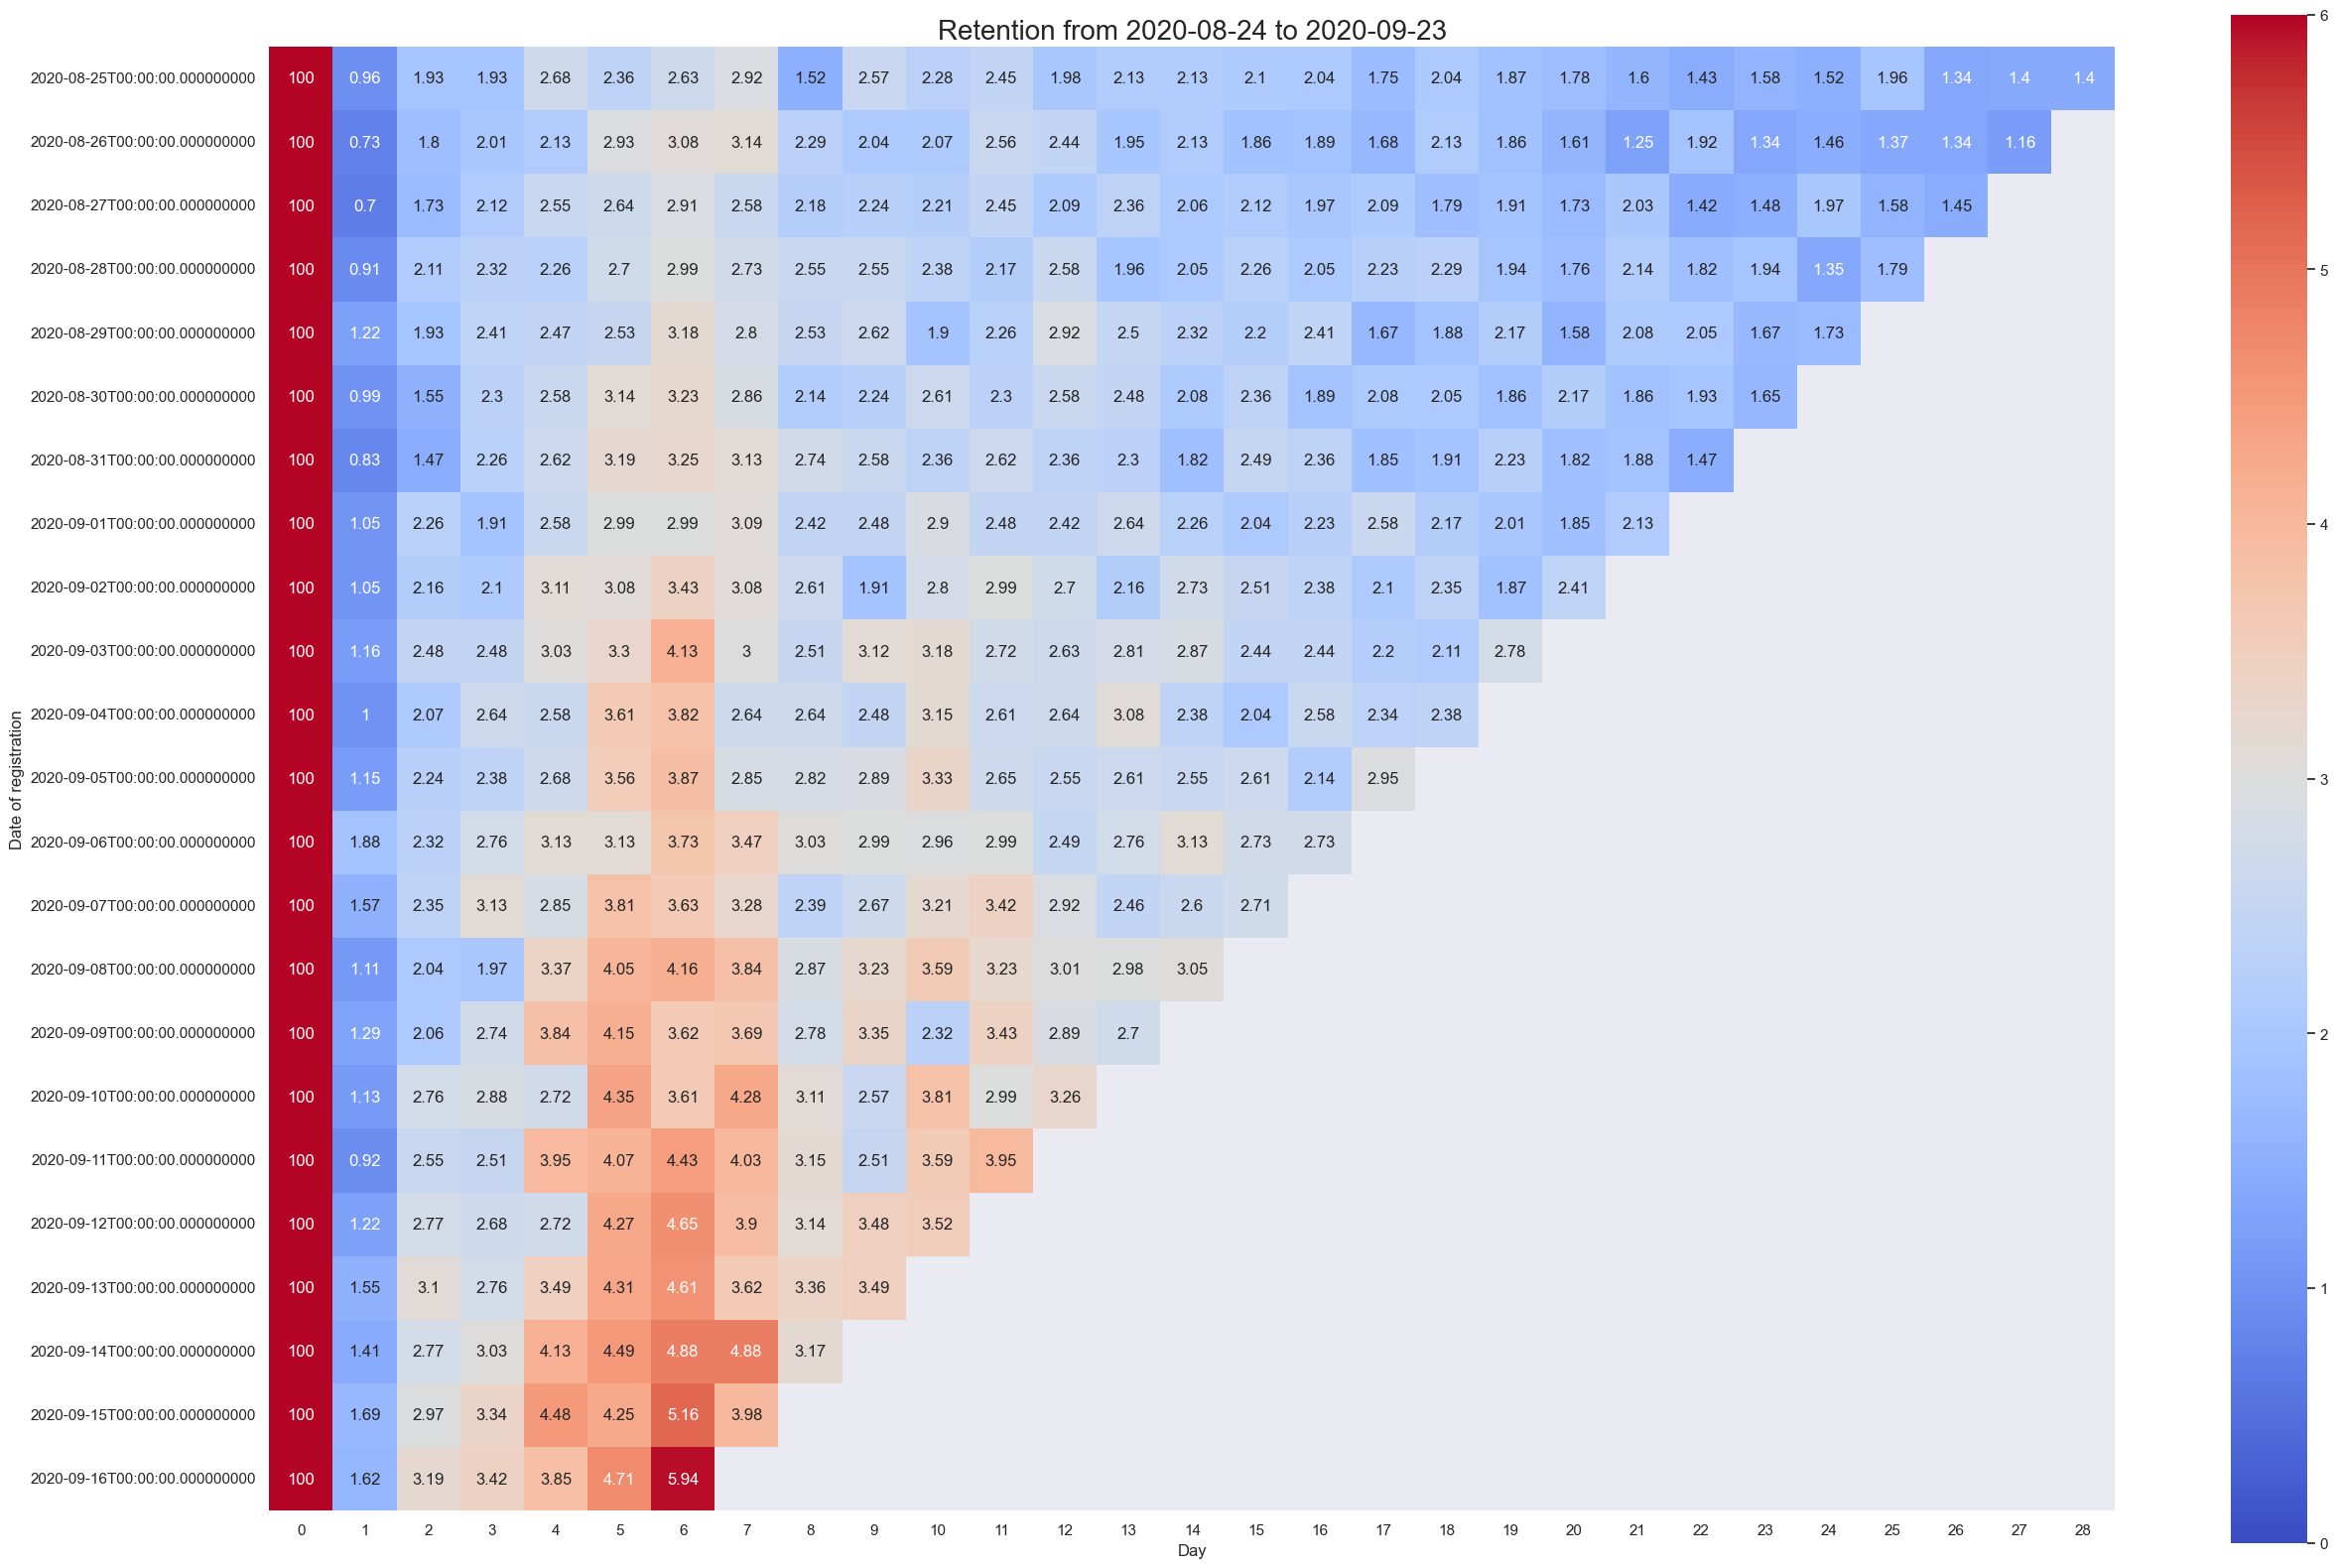

In [18]:
#Визуализация таблицы
plt.figure(figsize=(30, 20))
plt.title('Retention from {} to {}'.format(start_date, end_date), fontsize=20)
sns.heatmap(retention_2000, annot=True, cmap= 'coolwarm', fmt='.3g', vmin=0.0, vmax=6, square=True)
plt.ylabel('Date of registration')
plt.xlabel('Day')
plt.show() 

## Задание №2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Загрузка и предобработка данных

In [31]:
df=pd.read_csv('Проект_1_Задание_2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [4]:
# Проверям данные внутри датафрейма

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
# Убираем дуюликаты при их наличии

df.drop_duplicates()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [136]:
# Введем дополнительный параметр CR в покупку: если revenue > 0 , то CR=1 ,иначе CR=0

df['CR']=np.where(df['revenue'] > 0 , 1, 0)
df

,user_id,revenue,testgroup,CR
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


### Предварительное изучение имеющихся данных

In [7]:
# Настройка графиков по умолчанию
sns.set(
    font_scale =1.5,
    style      ="whitegrid",
    rc         ={'figure.figsize':(10,10)}
)

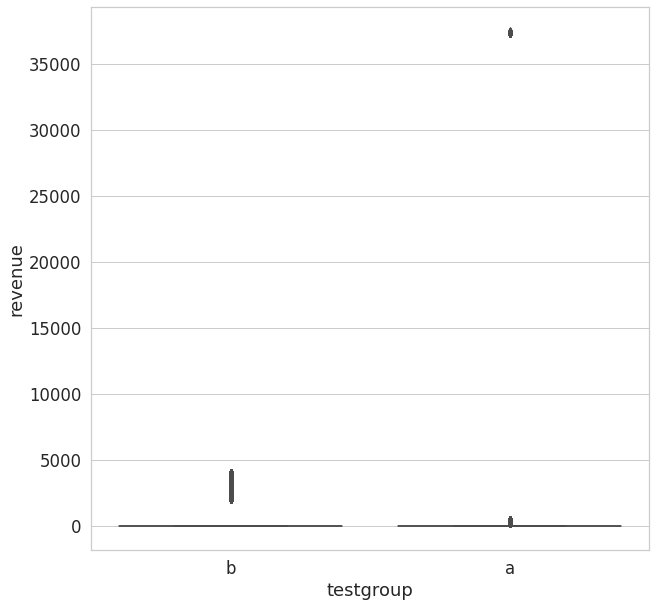

In [8]:
# Построим боксплот по имеющимся данным с разделением на группы

ax = sns.boxplot(x = 'testgroup', y = 'revenue', data = df)

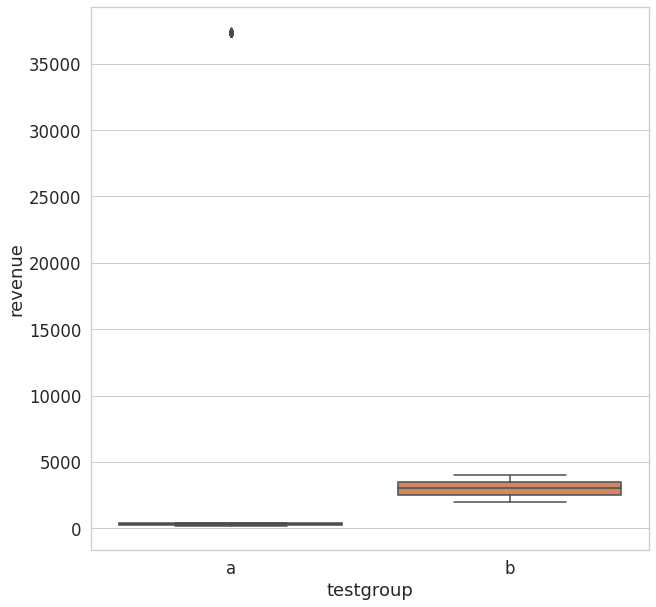

In [9]:
# Построим боксплот по имеющимся данным с разделением на группы и оставив ненулевые значения revenue

ax = sns.boxplot(x = 'testgroup', y = 'revenue', data = df.query('revenue>0'))

**Промежуточный вывод:** наблюдаем некоторое количество выбросов в группе "а" со значениями revenue больше 35 000, в группе "b" выбросов нет

Рассмотрим детальнее распределение значений в группе "а"

In [10]:
# Количество ненулевых значений revenue в группе a

df.query('revenue>0 and testgroup=="a"').shape

(1928, 4)

In [11]:
# Количество значений revenue в группе a, которые больше 35000

df.query('revenue>35000 and testgroup=="a"').shape

(123, 4)

In [12]:
# Количество значений revenue в группе a, которые больше 5000 и меньше 35000

df.query('revenue<35000 and revenue>5000 and testgroup=="a"').shape

(0, 4)

In [13]:
# Найдем 90-95 перцентили, чтобы оценить границу выбросов  

df.query('revenue>0 and testgroup=="a"').revenue.quantile(q=[0.90,0.91, 0.92, 0.93, 0.94, 0.95])

0.90      393.30
0.91      396.00
0.92      397.00
0.93      399.00
0.94    37295.00
0.95    37299.65
Name: revenue, dtype: float64

**Промежуточные выводы по значениям группы "a":**

- в группе "а" всего 1928 ненулевых значений revenue
- из них 123 выброса со значением revenue более 35000
- в промежутке между значениями revenue 500 и 35000 нет ни одной точки
- значениям revenue более 35000 соответствует 93-ий перцентиль 

С учетом имеющихся данных невозможно однозначно объяснить природу найденных выбросов. Чтобы глубже проанализировать природу выбросов необходимы детальные данные о сессиях пользователей с выбросами и исторические данные о работе приложения за предыдущие периоды. Это помогло бы понять какой подход в отношении выбросов нужно использовать и какой из статистических критериев оценки средних значений в группах будет наиболее валидным при оценке результатов такого А/В-теста.  


В настощем задании с учетом того, что детальных данных по сессиям пользователей нет, как и исторических данных за предыдущие периоды, попробуем оценить различия средних значений в группах как с учетом выбросов в группе "а", так и без них:

 - В первом случае, возьмем все значения revenue для групп "а" и "b" без исключения. 

 - Во втором случае отбросим топ пользователей в группе "а" по 93-му перцентилю и для того, чтобы уравновесить данное отсечение, отсечем топ пользователей c ненулевой revenue и в группе "b", также по 93-му перцентилю.
 
После этого сравним полученные результаты и сделаем выводы.



_________

**Для анализа выберем следующие метрики:** 
- ARPU - покажет общую картину прибыли по пользователям.
- ARPPU и CR в оплату - покажут причины изменения ARPU (либо средний пользователь стал больше/меньше платить, либо большее/меньшее количество пользователей стали платящими).
______________________________

### Подсчет ARPU, ARPPU и CR в оплату

**Начнем с ARPU**

ARPU = доход за период / количество пользователей за период

В качестве уровня значимости по умолчанию возьмем 5%

Выделим revenue для тестовой и контрольной групп

In [14]:
a = df.query('testgroup=="a"').revenue
b = df.query('testgroup=="b"').revenue

Посмотрим на распределения revenue в группах

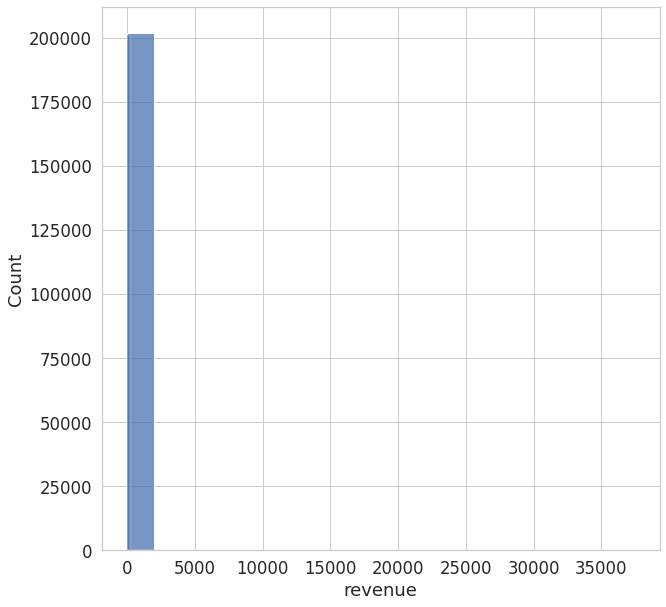

In [15]:
sns.histplot(a, kde=False)
sns.histplot(b, kde=False);

Попробуем отсечь нулевые значения revenue и построить распределение еще раз

In [16]:
a_rev = df.query('testgroup=="a" and revenue!=0').revenue
b_rev = df.query('testgroup=="b" and revenue!=0').revenue

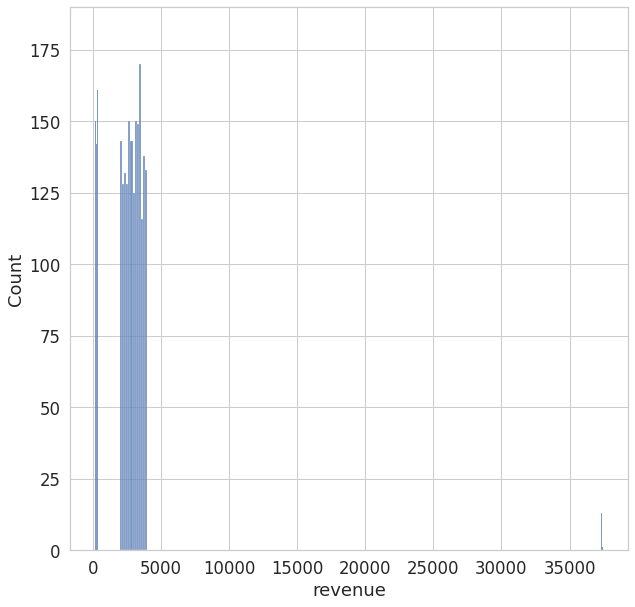

In [17]:
sns.histplot(a_rev, kde=False)
sns.histplot(b_rev, kde=False);

**Промежуточный вывод:** распределение явно не является нормальным. Пролагорифмировать не получится из-за большого количества нулевых значений в обеих группах. Для большей уверенности проведем тест на нормальность Шапиро-Уилка, при этом для большей точности теста возьмем только часть значений из групп

**Нулевая гипотеза (H0):** распределения значений revenue в группах "a" и "b" нормальные

**Альтернативная гипотеза (H1):** распределения значений revenue в группах "a" и "b" не являются нормальными

In [18]:
a_sample = a.sample(1000, random_state=17)
b_sample = b.sample(1000, random_state=17)

In [19]:
stats.shapiro(a_sample)

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [20]:
stats.shapiro(b_sample)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Как и следовало ожидать, отвергаем **H0**, оба распределения не являются нормальными.

Проверим гомогенность дисперий выборок

In [21]:
sp.stats.levene(b,a)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест на гомогенность дисперсий показал равенство дисперсий в выборках (p-value > 0,05)

Для оценки различий в группах применим два критерия: непараметрический критерий Манна-Уитни и бутстрэп.

Но перед этим оценим разницу средних значений в группах

In [22]:
round((b.mean() - a.mean())/a.mean()*100,2)

5.26

Получаем те самые 5% процентов из условия задачи, проверим статистическую значимость отличия

**Применим для оценки различий в распределениях revenue групп критерий Манна-Уитни:**

**Нулевая гипотеза (H0):** Разницы в распределениях значений revenue в тестовой и контрольной группе нет, для бизнеса нет ни пользы, ни вреда.

**Альтернативная гипотеза (H1):** Разница в распределениях значений revenue в тестовой и контрольной группах существует.

In [23]:
sp.stats.mannwhitneyu(b,a)

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

Критерий Манна-Уитни показал, что распределение revenue в контрольной группе приблизительно соответствует распределению revenue в тестовой группе (p-value > 0,05), с учетом принятого уровня значимости 5%, отклоняем **H1**, посмотрим какой результат даст **бутстрэп:**

**Нулевая гипотеза (H0):** Разницы между ARPU в тестовой и контрольной группе нет, для бизнеса нет ни пользы, ни вреда.

**Альтернативная гипотеза (H1):** Разница между ARPU в тестовой и контрольной группе есть, польза для бизнеса существует в случае, если разница положительна.

In [48]:
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [46]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрэпа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

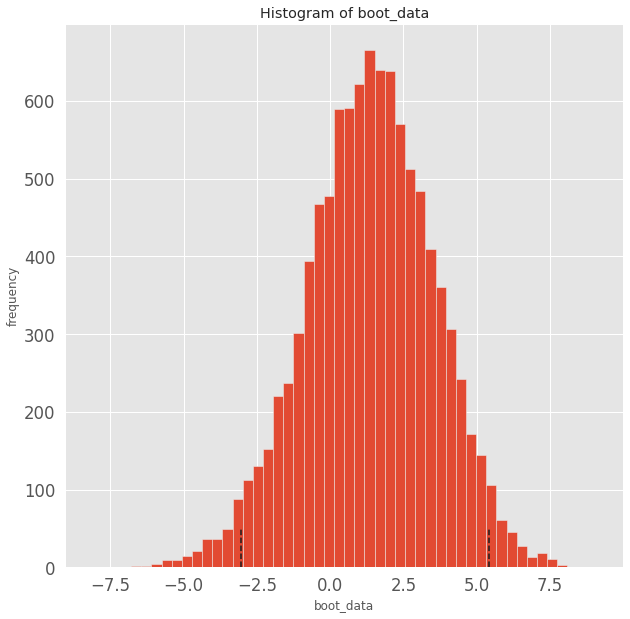

{'ci':               0
 0.025 -3.043663
 0.975  5.432471,
 'p_value': 0.5306389197960109}

In [26]:
get_bootstrap(
    b, # числовые значения первой выборки
    a, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

**Промежуточный вывод:** бутстрэп по среднему значению отклонил **H1** о различиях средних значений (p-value > 0,05)

_________________________________________

**Посмотрим, что даст оценка ARPPU**

ARPPU = доход за период **/** количество платящих пользователей за период

Подготовим данные по ненулевой revenue для теста Шапиро-Уилка

In [29]:
a_sample = a_rev.sample(1000, random_state=17)
b_sample = b_rev.sample(1000, random_state=17)

In [30]:
stats.shapiro(a_sample)

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)

In [31]:
stats.shapiro(b_sample)

ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)

Оба распределения не являются нормальными.

Проверим гомогенность дисперсий в выборках

In [32]:
sp.stats.levene(b_rev,a_rev)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Результаты теста указывают на то, что дисперсия в выборках по ненулевой revenue отличается 

Для оценки различий в группах снова применим два критерия: непараметрический критерий Манна-Уитни и бутстрэп.

Но перед этим оценим разницу средних значений в группах

In [33]:
round((b_rev.mean() - a_rev.mean())/a_rev.mean()*100,2)

12.75

Рост ARPPU в группе "b" почти на 13%, проверим статическую значимость отличия

**Применим для оценки различий в распределениях ненулевой revenue групп критерий Манна-Уитни:**

**Нулевая гипотеза (H0):** Разницы в распределениях значений ненулевой revenue в тестовой и контрольной группе нет, для бизнеса нет ни пользы, ни вреда.

**Альтернативная гипотеза (H1):** Разница в распределениях значений ненулевой revenue в тестовой и контрольной группах существует.

In [34]:
sp.stats.mannwhitneyu(b_rev,a_rev)

MannwhitneyuResult(statistic=3258025.0, pvalue=0.0)

Критерий Манна-Уитни показал, что распределения ненулевой revenue в тестовой и контрольной группах отличаются (p-value < 0,05), посмотрим какой результат даст **бутстрэп**.

**Нулевая гипотеза (H0):** Разницы между ARPPU в тестовой и контрольной группе нет, для бизнеса нет ни пользы, ни вреда.

**Альтернативная гипотеза (H1):** Разница между ARPPU в тестовой и контрольной группе есть, польза для бизнеса существует в случае, если разница положительна.

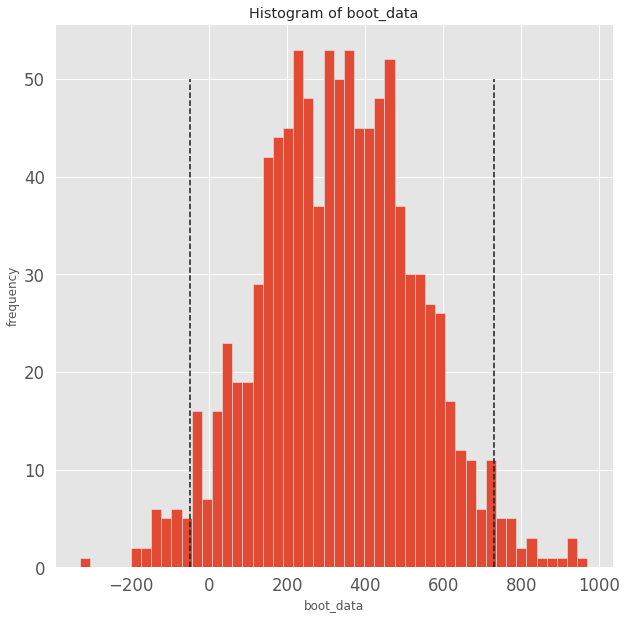

{'ci':                 0
 0.025  -49.374209
 0.975  729.933908,
 'p_value': 0.09627351694508916}

In [35]:
get_bootstrap(
    b_rev, # числовые значения первой выборки
    a_rev, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Для ARPPU бутстрэп уже не так однозначен и результат очень близок к отклонению **H0** о равенстве ARPPU групп

**Посмотрим, что даст оценка CR**

CR = платящие пользователи / общее количество пользователей

In [38]:
a_cr = df.query('testgroup=="a"').CR
b_cr = df.query('testgroup=="b"').CR

Посмотрим на распределение значений CR

In [39]:
# Настройка графиков по умолчанию
sns.set(
    font_scale =1.5,
    style      ="whitegrid",
    rc         ={'figure.figsize':(10,10)}
)

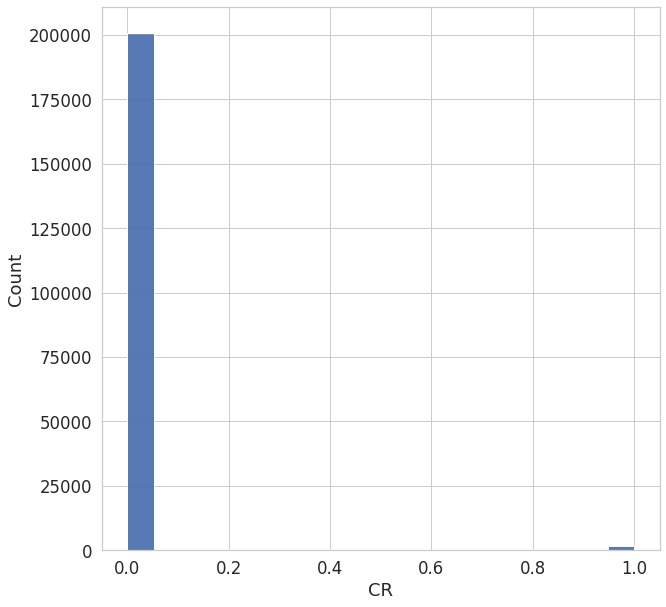

In [40]:
sns.histplot(a_cr, kde=False)
sns.histplot(b_cr, kde=False);

Имеем биномиальное распределение (0 и 1), для оценки которого применим бутстрэп, но сначала оценим сами средние значения CR

In [41]:
round((b_cr.mean() - a_cr.mean())/a_cr.mean()*100,2)

-6.64

Расчеты средних показывают, что конверсия в тестовой группе упала на 6%, проверим статистическую значимость данного отличия

In [1]:
#Используем для этого критерий Хи-квадрат Пирсона
#kf_data = np.array([[stat_df.amount_user.loc[0],stat_df.amount_customer.loc[0]], [stat_df.amount_user.loc[1],stat_df.amount_customer.loc[1]]])
#kf = chi2_contingency(kf_data)
#print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

**Используем для этого бутстрэп:**

**Нулевая гипотеза (H0):** Разницы между CR в тестовой и контрольной группе нет, для бизнеса нет ни пользы, ни вреда.

**Альтернативная гипотеза (H1):** Разница между CR в тестовой и контрольной группе есть, польза для бизнеса существует в случае, если разница положительна.

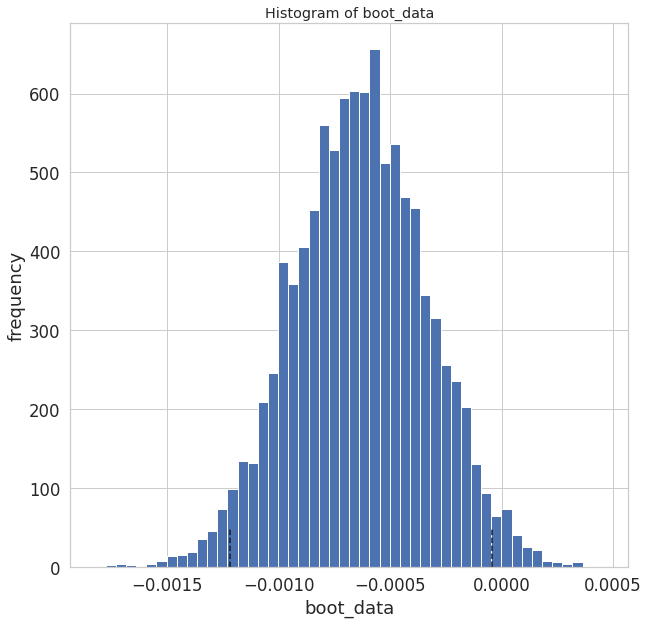

{'ci':               0
 0.025 -0.001219
 0.975 -0.000044,
 'p_value': 0.03447910338997016}

In [42]:
get_bootstrap(
    b_cr, # числовые значения первой выборки
    a_cr, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

**Промежуточный вывод:** с учетом полученных результатов (p-value < 0,05), отклоняем **Н0** о равенстве CR в группах, конверсия в контрольной группе больше, чем в тестовой, на 6%. 

**ИТОГ ПО ЗАДАНИЮ:** оценка различий ARPU и ARPPU в группах не дала внятных статистически значимых результатов, при этом CR в контрольной группе на 6% больше, чем в тестовой.

Результаты настоящего А/В теста нельзя считать достаточными и однозначными для раскатки эксперимента на всю аудиторию. 

Наблюдаемые выбросы в контрольной группе и их полное отсутствие в тестовой группе вносят значительные искажения в наблюдаемую картину распределения revenue, поэтому в самые короткие сроки необходимо детально проверить сессии с выбросами и понять их природу, сравнить их с историческими данными. Также необходимо проверить систему сплитования, возможно, очень большие чеки по каким-то причинам оказались только в контрольной группе.

После сравнения результатов эксперимета с иторическими данными, детального изучения сессий пользоватей с выбросами, проверки системы сплитования необходимо провести повторный эксперимент, так как введенные изменения в явном виде значительно увеличивают revenue "малых" чеков.
______________________________

## Задание №3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Метрики, которые могли бы быть использованы для оценки эффективности того или иного игрового события:**

1) DAU, WAU, MAU - можно использовать эти метрики для оценки общей активности аудитории во время проведения тематического события. 

2) Использовать метрики для оценки сессий пользователей - среднее количестве сессий на одного пользователя, средняя продолжительность сессии, среднее количество сессий каждого типа - одиночные или кооперативные, фиксировать тип устройства сессии.

3) avg. DAU/MAU = stickness ratio, чтобы учитывать насколько часто пользователи, в течение периода проведения события, "остаются" в продукте.

4) Количество новых/отвалившихся/вернувшихся пользователей - зачастую тематичекие события имеют большую динамику привлечения новых пользователей, так как это в том числе хорошая возможность стартануть (в том числе заново для старых пользователей, которые могут создать новый аккаунт, например), также в этот период много игроков возвращаются в сервис, а среднее количество отвалившихся пользователей падает (если тематическое событие действительно привлекательно и интересно пользователям). 

5) Выручка, ARPU, ARPPU, CR в покупку платных предметов - важно понимать как меняются показатели доходов во время проведения событий по отношению к обычным периодам. 

6) Retention rate/churn rate - для оценки уровня удержания/оттока когорт пользователей, вовлеченных в событие (интересуют когорты сформировавшиеся как до проведения тематического события, так и когорты сформировавшиеся во время проведения тематического события).

7) Доля новых пользователей - следить за тем как тематическое событие привлекает новых пользователей.

8) Необходимо выделить этапы воронки (уровни игры) и замерять на каждом этапе уровень конверсии (абсолютную и относительную) и конверсионное окно (среднее время прохождения уровня), чтобы понимать какие уровни могут вызывать у пользователей большие сложности и могут служить фактором оттока, также необходимо следить и за тем, чтобы уровни не были слишком легкими, так как это также может послужить излишнему оттоку пользователей.

9) LTV - поможет оценить как проводимое в игре событие меняет динамику доходов, извлекаемых из когорт по датам. 

10) ROI, ROMI, ROAS - помогут оценить как в период проведения события меняется динамика окупаемости когорт пользователей, привлекаемых платно.

11) CPI (Cost per install) и CAC - для пользователей, привлеченных платно, необходимо отслеживать динамику изменения расходов на одну установку и последующие конверсии в игре, так как некоторые определенные внутриигровые события и их условия могут быть триггерами для большого количества относительно дешевых установок приложения и внутриигровых конверсий.

12) customer satisfaction score, CSAT - необходимо отслеживать как проводимое в игре событие влияет на динамику уровеня удовлетворенности пользователей.

13) Также необходимо учитывать изменения Фактора виральности (К−фактор=X⋅Y⋅Z), так как в период проведения некоторых акций путем добавления определенных условий можно влиять на:
 - X — процент пользователей, которые пригласили новых пользователей
 - Y — среднее число людей, которых пригласил единичный пользователь
 - Z — число пользователей, принявших приглашение
 
14) Также обязательно необходимо учитывать количество и степень распределения среди аудитории игровой валюты и игровых предметов, полученных пользователями во время проведения событий, и то каким образом и как быстро они расходуют полученные ресурсы в игре, и как это влияет, например на LTV, retention, ROI, ARPU, ARPPU, CR в покупку платных предметов и т.д. уже после окончания внутриигрового события.

15) Показатель Rage quit и Rage deinstall - помогут оценить какие уровни вызывают наибольший гнев пользователей, который приводит в последствии к выходу из игры и даже ее удалению.
____________________________

**В случае усложнения механики внутриигрового события** набор метрик, наверное, притерпел бы немного изменений, скорее всего сместился бы аналитический фокус и некоторые метрики, которые наиболее репрезентативно показывают влияние сложности игры на аудиторию, приобрели бы большее значение в оценке эффективности события, например:

1) retention rate - какое количество пользователей остаются вовлеченными в игру не смотря на возросшую сложность.

2) DAU, WAU, MAU - какое количество пользователей заходят в игру сталкиваясь с более сложной механикой события.

3) avg. DAU/MAU = stickness ratio - какое количество пользователей регулярно остаются в игре, не смотря на возросшую сложность. 

4) customer satisfaction score, CSAT - какая доля негативных/позитивных отзывов наблюдается при введении более сложной механики события.

5) Количество и степень распределения среди аудитории игровой валюты и игровых предметов, полученных в рамках события с усложненной механикой, так как по идее с увеличением сложности механики события добыть те или иные игровые предметы становится сложнее и соответственно было бы очень интересно понаблюдать за теми группами пользователей, которые все таки получили те или иные игровые награды (как эволюционирует их retention, LTV, ROI после проведения события с усложненной механикой).

6) Показатель Rage quit и Rage deinstall - помогут определить слишком сложные для игроков места

Одно из изменений в системе метрик, которое бы однозначно следовало ввести касается методики подсчета уровня конверсии и конверсионных окон на этапах воронки (уровней игры), где также теперь бы следовало подсчитывать обратную конверсию, т.е какой процент пользователей (или сессий) из общего числа, для которых случилось событие "откат на несколько уровней назад", а также расчитывать "суммарное конверсионное окно" для преодоления того или иного уровня, так как в событии с усложненной механикой возможны ситуации, когда пользователь проходит один уровень несколько раз и тратит на это много времени, что в перспективе может служить для него фактором ухода из игры. Введение таких изменений в систему подсчета эфективности воронки поможет эфективнее оценивать событие с усложенной механикой, вылавливать инсайты,а в последствии точнее настраивать уровень сложности тех или иных этапов.